# Which features help in predicting price?

# 1. Gather

In [1]:
# Import necessary libraries
import pandas as pd
from sklearn.impute import SimpleImputer
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor

import matplotlib.pyplot as plt
# Magic word for producing visualizations in notebook
%matplotlib inline

In [2]:
# Load in listings data.
listings_df = pd.read_csv('listings.csv',sep=',')

# 2. Assess

In [3]:
# drop unwanted columns
drop_columns=['host_listings_count','calculated_host_listings_count','host_neighbourhood',
'neighbourhood','neighbourhood_cleansed','host_since','first_review','last_review','scrape_id',
 'last_scraped','experiences_offered','market','country_code', 'country', 'has_availability',
'calendar_last_scraped','requires_license','license','jurisdiction_names','listing_url',
 'thumbnail_url','medium_url','picture_url','xl_picture_url','host_url','host_thumbnail_url',
 'host_picture_url','host_id', 'host_name','host_location','host_about',
'host_response_time','host_acceptance_rate','host_verifications',
'street','city','state','smart_location','id','name', 'summary', 'space', 
'description', 'neighborhood_overview','notes', 'transit','latitude','longitude']
listings_df.drop(drop_columns, axis=1, inplace=True)
listings_df.shape

(3818, 44)

In [4]:
# The columns information of listings data
listings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 44 columns):
host_response_rate                  3295 non-null object
host_is_superhost                   3816 non-null object
host_total_listings_count           3816 non-null float64
host_has_profile_pic                3816 non-null object
host_identity_verified              3816 non-null object
neighbourhood_group_cleansed        3818 non-null object
zipcode                             3811 non-null object
is_location_exact                   3818 non-null object
property_type                       3817 non-null object
room_type                           3818 non-null object
accommodates                        3818 non-null int64
bathrooms                           3802 non-null float64
bedrooms                            3812 non-null float64
beds                                3817 non-null float64
bed_type                            3818 non-null object
amenities                          

# 3. Clean and Analyze

## 3.1. Handle Inconsistent Data

In [5]:
# Change the type of price features to float
price_cols=['price','weekly_price','monthly_price','security_deposit','cleaning_fee','extra_people']
listings_df[price_cols]=listings_df[price_cols].apply(lambda x: pd.to_numeric(x.str.translate({ord(i): None for i in '$,'})))
listings_df[price_cols].head(n=2)

,price,weekly_price,monthly_price,security_deposit,cleaning_fee,extra_people
0,85.0,NaN,NaN,NaN,NaN,5.0
1,150.0,1000.0,3000.0,100.0,40.0,0.0


**One record has wrong value('99\n98122'), so it is changed to '98122' because all the values of zipcode has similar format**

In [6]:
# Change ('99\n98122') to '98122'
listings_df.loc[listings_df['zipcode']=='99\n98122', 'zipcode'] = '98122'

## 3.2. Handle Missing Data

In [7]:
# Impute categorical variables with the most frequent,
# because this method is better for replace null values of categorical variables 
imp_obj= SimpleImputer(missing_values=np.nan, strategy='most_frequent')
obj_cols = listings_df.select_dtypes(include=['object']).columns
listings_df[obj_cols]= pd.DataFrame(data=imp_obj.fit_transform(listings_df[obj_cols]),
                                         index=listings_df[obj_cols].index, columns=obj_cols)
listings_df[obj_cols].isnull().sum().sum()

0

In [8]:
# Impute numeric values with mean
# because this method has better result than imputation with median
imp_num= SimpleImputer(missing_values=np.nan, strategy='mean')
num_cols = listings_df.drop(columns=['price']).select_dtypes(include=['float64', 'int64']).columns
listings_df[num_cols]= pd.DataFrame(data=imp_num.fit_transform(listings_df[num_cols]),
                                         index=listings_df[num_cols].index, columns=num_cols)
listings_df[num_cols].isnull().sum().sum()

0

## 3.3. Encode Categorical Features

In [9]:
# Dummy the categorical variables
cat_vars = ['host_response_rate', 'host_is_superhost','host_has_profile_pic', 'host_identity_verified',
            'neighbourhood_group_cleansed', 'zipcode', 'is_location_exact','property_type', 'room_type',
            'bed_type','calendar_updated', 'instant_bookable', 'cancellation_policy',
            'require_guest_profile_picture', 'require_guest_phone_verification']

for var in  cat_vars:
    listings_df = pd.concat([listings_df.drop(var, axis=1), 
                                    pd.get_dummies(listings_df[var], prefix=var, prefix_sep='_', drop_first=False)],
                                   axis=1)
listings_df.head()

,host_total_listings_count,accommodates,bathrooms,bedrooms,beds,amenities,square_feet,price,weekly_price,monthly_price,...,calendar_updated_yesterday,instant_bookable_f,instant_bookable_t,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict,require_guest_profile_picture_f,require_guest_profile_picture_t,require_guest_phone_verification_f,require_guest_phone_verification_t
0,3.0,4.0,1.0,1.0,1.0,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",854.618557,85.0,788.481832,2613.33619,...,0,1,0,0,1,0,1,0,1,0
1,6.0,4.0,1.0,1.0,1.0,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",854.618557,150.0,1000.000000,3000.00000,...,0,1,0,0,0,1,0,1,0,1
2,2.0,11.0,4.5,5.0,7.0,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",854.618557,975.0,788.481832,2613.33619,...,0,1,0,0,0,1,1,0,1,0
3,1.0,3.0,1.0,0.0,2.0,"{Internet,""Wireless Internet"",Kitchen,""Indoor ...",854.618557,100.0,650.000000,2300.00000,...,0,1,0,1,0,0,1,0,1,0
4,2.0,6.0,2.0,3.0,3.0,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",854.618557,450.0,788.481832,2613.33619,...,0,1,0,0,0,1,1,0,1,0


In [10]:
# Remove unwanted characters from amenities feature and split it to rows, then conver them into array 
amenities = np.array(listings_df['amenities'].map(lambda a: a.strip('{}').replace('"', '').split(',')))
amenities

array([list(['TV', 'Cable TV', 'Internet', 'Wireless Internet', 'Air Conditioning', 'Kitchen', 'Heating', 'Family/Kid Friendly', 'Washer', 'Dryer']),
       list(['TV', 'Internet', 'Wireless Internet', 'Kitchen', 'Free Parking on Premises', 'Buzzer/Wireless Intercom', 'Heating', 'Family/Kid Friendly', 'Washer', 'Dryer', 'Smoke Detector', 'Carbon Monoxide Detector', 'First Aid Kit', 'Safety Card', 'Fire Extinguisher', 'Essentials']),
       list(['TV', 'Cable TV', 'Internet', 'Wireless Internet', 'Air Conditioning', 'Kitchen', 'Free Parking on Premises', 'Pets Allowed', 'Pets live on this property', 'Dog(s)', 'Cat(s)', 'Hot Tub', 'Indoor Fireplace', 'Heating', 'Family/Kid Friendly', 'Washer', 'Dryer', 'Smoke Detector', 'Carbon Monoxide Detector', 'Essentials', 'Shampoo']),
       ...,
       list(['Cable TV', 'Wireless Internet', 'Kitchen', 'Free Parking on Premises', 'Breakfast', 'Pets live on this property', 'Dog(s)', 'Cat(s)', 'Heating', 'Washer', 'Dryer', 'Smoke Detector', 'First Ai

In [11]:
# Get all unique values from amenities, then conver them into array
amenities_groups = np.unique(np.concatenate(amenities))[1:]
amenities_groups

array(['24-Hour Check-in', 'Air Conditioning', 'Breakfast',
       'Buzzer/Wireless Intercom', 'Cable TV', 'Carbon Monoxide Detector',
       'Cat(s)', 'Dog(s)', 'Doorman', 'Dryer', 'Elevator in Building',
       'Essentials', 'Family/Kid Friendly', 'Fire Extinguisher',
       'First Aid Kit', 'Free Parking on Premises', 'Gym', 'Hair Dryer',
       'Hangers', 'Heating', 'Hot Tub', 'Indoor Fireplace', 'Internet',
       'Iron', 'Kitchen', 'Laptop Friendly Workspace',
       'Lock on Bedroom Door', 'Other pet(s)', 'Pets Allowed',
       'Pets live on this property', 'Pool', 'Safety Card', 'Shampoo',
       'Smoke Detector', 'Smoking Allowed', 'Suitable for Events', 'TV',
       'Washer', 'Washer / Dryer', 'Wheelchair Accessible',
       'Wireless Internet'], dtype='<U26')

In [12]:
def convert_amenties_to_boolean(amenities_groups, amenities):
    
    '''
    INPUT
    amenities_groups - an array containing all unique values of amenities
    amenities - an array containing all values of amenities
    
    OUTPUT
    amenties_boolean - an array containing boolean values of amenities
    
    Perform to obtain the correct X and y objects
    This function cleans df using the following steps to produce X and y:
    1. Create an empty array with all zeros
    2. substitute with 1 if value of amenities_groups is found in amenities rows and vice versa
    '''
    amenties_boolean = np.empty((amenities.shape[0], amenities_groups.shape[0]))
    for i, row in enumerate(amenities):
        amns = amenities_groups.copy()
        for j, amn in enumerate(amns):
            if amn in amenities[i]:
                amenties_boolean[i,j] = True
            else:
                amenties_boolean[i,j] = False
    return amenties_boolean

#Use the function to convert values to 0 or 1
amenities= convert_amenties_to_boolean(amenities_groups, amenities)
amenities

array([[0., 1., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 1., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [13]:
# Reset index of the the dataframe
listings_df = listings_df.reset_index(drop=True)

In [14]:
# Add amenities to the dataframe
listings_df = pd.concat([listings_df.drop('amenities', axis=1), 
                              pd.DataFrame(data=amenities, columns=amenities_groups)], axis=1)

In [15]:
# Change the type of columns with uint8 to float, to apply feature scaling without any future warning 
uint8_cols = listings_df.select_dtypes(include=['uint8']).columns
listings_df[uint8_cols]=listings_df[uint8_cols].astype('float64')

# 4. Model

## 4.1. Split data into features and target value

In [16]:
# Create X variable with all features without price
X= listings_df.drop(columns=['price'])

# Create Y variable with only price feature
y= listings_df['price']

## 4.2. Apply features Scaling

In [17]:
# Apply feature scaling to the listings data.
st_scaler= StandardScaler()
X= pd.DataFrame(data=st_scaler.fit_transform(X), index=X.index, columns=X.columns) 

## 4.3. Split data into training and testing

In [18]:
# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.25, random_state=42)

## 4.4. Train model

In [19]:
def get_RMSE(model):
        
    '''
    INPUT
    model - training model
    
    OUTPUT
    model_rmse - RMSE value of the given model
    
    Perform to obtain RMSE value
    This function cleans df using the following steps to produce X and y:
    1. predict value of training data
    2. calculate MSE 
    3. Calculate RMSE
    '''
    y_predict = model.predict(X_train)
    model_mse = mean_squared_error(y_train, y_predict)
    model_rmse = np.sqrt(model_mse)
    
    return model_rmse

### 4.4.1 Linear Regression

In [20]:
# Create linear regression model
lin_reg = LinearRegression(normalize=True)

# Fit the model
lin_reg.fit(X_train, y_train)

# Get RMSE value
lin_reg_rmse= get_RMSE(lin_reg)

print('RMSE: {:.4}'.format(lin_reg_rmse))

RMSE: 4.31e+14


### 4.4.2 Lasso Regularization

In [21]:
# Create linear regression model with lasso regularization.
lasso_reg = Lasso()

# Fit the model
lasso_reg.fit(X_train, y_train)

# Get RMSE value
lasso_reg_rmse= get_RMSE(lasso_reg)

print('RMSE: {:.4}'.format(lasso_reg_rmse))

RMSE: 49.11


### 4.4.3 ElasticNet Regularization

In [22]:
# Create linear regression model with ElasticNet regularization
elas_reg = ElasticNet()

# Fit the model
elas_reg.fit(X_train, y_train)

# Get RMSE value
elas_reg_rmse= get_RMSE(elas_reg)

print('RMSE: {:.4}'.format(elas_reg_rmse))

RMSE: 50.59


### 4.4.4 RandomForest Regression

In [23]:
# Create RandomForest Regression model
forest_reg = RandomForestRegressor(n_estimators=10)

# Fit the model
forest_reg.fit(X_train, y_train)

# Get RMSE value
forest_reg_rmse= get_RMSE(forest_reg)

print('RMSE: {:.4}'.format(forest_reg_rmse))

RMSE: 21.83


**The best model is RandomForest Regression, because it has the lowest value of RMSE**

## 4.5. Improve chosen model

In [24]:
# Set GridSearchCV parameters 
parameters = {
    'bootstrap': [True, False],
    'n_estimators': [50, 100, 200],
    'max_features': ['auto', 'sqrt'],
    'max_depth' : [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
    
}

# Create GridSearchCV
forest_reg_cv= GridSearchCV(forest_reg, parameters,cv=3)

# Fit model
forest_reg_cv.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'bootstrap': [True, False], 'n_estimators': [50, 100, 200], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [25]:
# Get best parameter
forest_reg_cv.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [26]:
# Create RandomForest Regression model with best parameter
forest_reg_imp = forest_reg_cv.best_estimator_
y_predict_imp = forest_reg_imp.predict(X_test)

# Get RMSE value
forest_reg_mse_imp = mean_squared_error(y_test, y_predict_imp)
forest_reg_rmse_imp = np.sqrt(forest_reg_mse_imp)

print('RMSE: {:.4}'.format(forest_reg_rmse_imp))

RMSE: 47.91


# 5. Visualize

In [35]:
# Get feature_importances of model
feature_importances = forest_reg_cv.best_estimator_.feature_importances_

# Sort feature importance and get the first 20 features
feature_importances_df= pd.DataFrame(data=feature_importances, index=X.columns) 
feature_importances_sorted=feature_importances_df[0].sort_values(ascending=False)
feature_importances_sorted_10=feature_importances_sorted[:10]
feature_importances_sorted_10

bedrooms                          0.337871
weekly_price                      0.172749
bathrooms                         0.067545
room_type_Entire home/apt         0.046585
cleaning_fee                      0.040969
calendar_updated_13 months ago    0.025626
accommodates                      0.025437
security_deposit                  0.023404
reviews_per_month                 0.016944
availability_365                  0.016464
Name: 0, dtype: float64

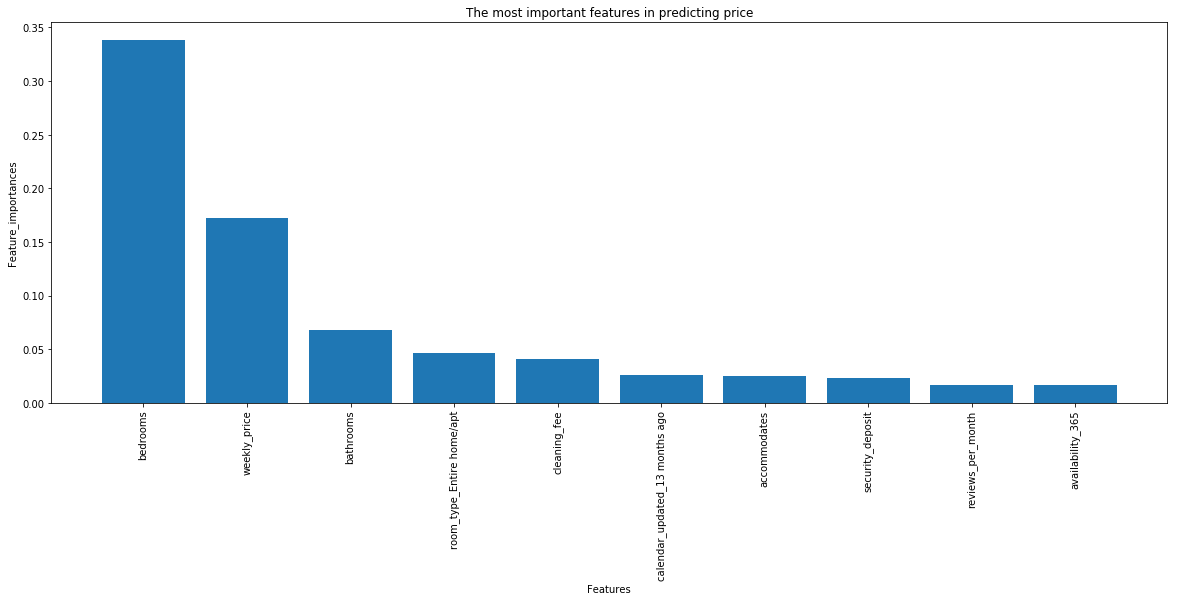

In [36]:
# Plot The most important features in predicting price
plt.figure(figsize=(20,7))
plt.bar(feature_importances_sorted_10.index,feature_importances_sorted_10)
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Feature_importances')
plt.title('The most important features in predicting price')
plt.show()

**Based on the above graph, The top 10 features to predict price are:**
1.	bedrooms: The number of bedrooms.
2.	weekly_price: The weekly cost of the listing.
3.	bathrooms: The number of bathrooms.
4.	room_type_Entire home/apt: Airbnb hosts can list entire homes/apartments, private or shared rooms.
5.	cleaning_fee: The cost of cleaning service.
6.	calendar_updated_13 months ago: The last time, the listing was reserved.
7.	accommodates: The number of people to be accommodated.
8.	security_deposit: The security deposit amount
9.	reviews_per_month: The number of monthly reviews.
10.	availability_365: Number of available days listed. 